In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize, RandAugment
from sklearn.metrics import f1_score
from vit_pytorch import ViT

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-100 dataset with augmentations
transform_train = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    RandAugment(num_ops=2, magnitude=9),  # Add RandAugment
    ToTensor(),
    Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = Compose([
    ToTensor(),
    Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)


/home/whalenlex/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define ViT model
model = ViT(
    image_size=32,
    patch_size=4,
    num_classes=10,
    dim=168,
    depth=8,
    heads=4,
    mlp_dim=128
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [3]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {num_params:,}")

Number of parameters in the model: 1,767,602


In [4]:
# Define the training loop
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(true_labels, predicted_labels, average='macro')

    return epoch_loss, epoch_acc, epoch_f1

val_losses = []
val_accs = []
val_f1s = []

# Define the validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(true_labels, predicted_labels, average='macro')
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)
    val_f1s.append(epoch_f1)

    return epoch_loss, epoch_acc, epoch_f1

import time
# Training loop
num_epochs = 100
start_time = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = validate(model, test_loader, criterion, device)
    # print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}")
end_time = time.time()
total_time = end_time-start_time
print(total_time)

2919.737824678421


In [5]:
import json
data = {
    "val_losses": val_losses,
    "val_accs": val_accs,
    "val_f1s": val_f1s,
    'time':total_time
}

# Save the data to a JSON file
with open("val_vit.json", "w") as file:
    json.dump(data, file)


In [6]:
import matplotlib.pyplot as plt

In [7]:
len(val_losses)

100

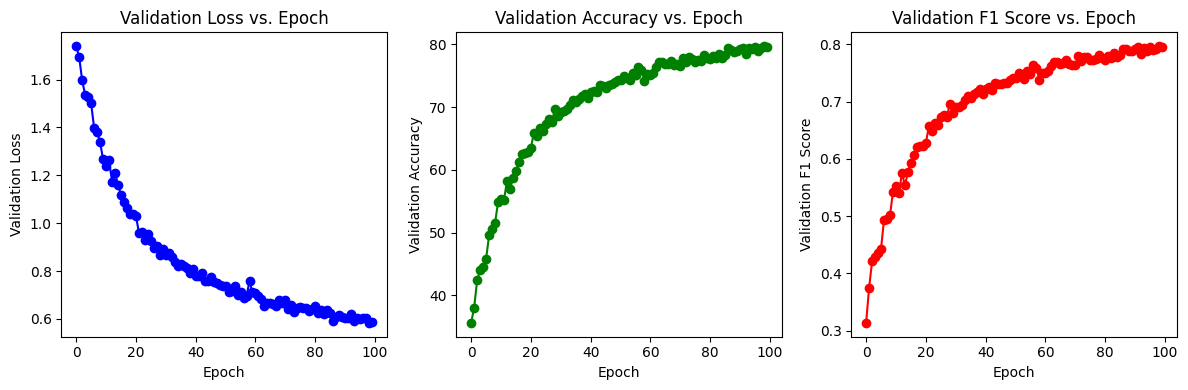

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(val_losses, 'bo-')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Epoch')

plt.subplot(1, 3, 2)
plt.plot(val_accs, 'go-')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epoch')

plt.subplot(1, 3, 3)
plt.plot(val_f1s, 'ro-')
plt.xlabel('Epoch')
plt.ylabel('Validation F1 Score')
plt.title('Validation F1 Score vs. Epoch')

plt.tight_layout()
plt.show()